In [1]:
# Jupyter Notebook to create interactive map of Southern California
# by Marilyn Waldman (mdwaldman22@gmail.com)


import pandas as pd
import numpy as np
import geopandas as gpd
import streamlit as st
import folium as fl

from folium.plugins import FastMarkerCluster,MarkerCluster,MiniMap
import streamlit_folium as sf
import branca.colormap as cm
import os as os
import pathlib
import base64
import re
import random
import json
import requests
import zipfile

In [2]:
STREAMLIT_STATIC_PATH = pathlib.Path(st.__path__[0]) / "static"
print(STREAMLIT_STATIC_PATH)
# We create a downloads directory within the streamlit static asset directory
# and we write output files to it
DOWNLOADS_PATH = STREAMLIT_STATIC_PATH / "downloads"
if not DOWNLOADS_PATH.is_dir():
    DOWNLOADS_PATH.mkdir()  

/Users/marilynwaldman/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/streamlit/static


In [3]:
def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

In [100]:
#test download from Google drive -

out_zip = os.path.join(DOWNLOADS_PATH, "Water_Districts.zip")
file_id = '1Ng9v8HQrTRd8BQUgIZFgbG2Ht0tCfcM2'
download_file_from_google_drive(file_id, out_zip)
zip_ref = zipfile.ZipFile(out_zip, "r")
zip_ref.extractall(DOWNLOADS_PATH)
#out_dir = os.path.join(DOWNLOADS_PATH,"Water_Districts/Water_Districts.shp" )
#gdf = gpd.read_file(out_dir)
waterdistict_gdf = gpd.read_file(out_zip.replace("zip", "shp"))

In [102]:
waterdistict_gdf.head(1)
#waterdistict_gdf_utm10 = waterdistict_gdf.to_crs("epsg:26910")

,OBJECTID,AGENCYNAME,SOURCE,AGENCYUNIQ,LASTMODIFI,MODIFIEDBY,SOURCECOMM,Date_Data_,GlobalID,geometry
0,1,Del Puerto Water District,ATLAS_WMAS,706,2021-04-27,ATLAS_WMAS,None,2021-04-27,{E53FAE01-633C-44AA-9958-3956EDF8E43D},"MULTIPOLYGON (((-13479198.992 4486699.420, -13..."


In [4]:
#test download from Google drive -

out_zip = os.path.join(DOWNLOADS_PATH, "CaliforniaCounties.zip")
#https://drive.google.com/file/d/1-J2JhrRHazBfbM7M_pwPB5D2XWGIthHJ/view?usp=sharing
file_id = '1-J2JhrRHazBfbM7M_pwPB5D2XWGIthHJ'
download_file_from_google_drive(file_id, out_zip)
zip_ref = zipfile.ZipFile(out_zip, "r")
zip_ref.extractall(DOWNLOADS_PATH)
ca_counties_gdf = gpd.read_file(out_zip.replace("zip", "shp"))

In [5]:
print(ca_counties_gdf.shape)
print(ca_counties_gdf.columns)
ca_counties_gdf.head()


(58, 59)
Index(['FID_', 'NAME', 'STATE_NAME', 'POP2010', 'POP10_SQMI', 'POP2012',
       'POP12_SQMI', 'WHITE', 'BLACK', 'AMERI_ES', 'ASIAN', 'HAWN_PI',
       'HISPANIC', 'OTHER', 'MULT_RACE', 'MALES', 'FEMALES', 'AGE_UNDER5',
       'AGE_5_9', 'AGE_10_14', 'AGE_15_19', 'AGE_20_24', 'AGE_25_34',
       'AGE_35_44', 'AGE_45_54', 'AGE_55_64', 'AGE_65_74', 'AGE_75_84',
       'AGE_85_UP', 'MED_AGE', 'MED_AGE_M', 'MED_AGE_F', 'HOUSEHOLDS',
       'AVE_HH_SZ', 'HSEHLD_1_M', 'HSEHLD_1_F', 'MARHH_CHD', 'MARHH_NO_C',
       'MHH_CHILD', 'FHH_CHILD', 'FAMILIES', 'AVE_FAM_SZ', 'HSE_UNITS',
       'VACANT', 'OWNER_OCC', 'RENTER_OCC', 'NO_FARMS07', 'AVG_SIZE07',
       'CROP_ACR07', 'AVG_SALE07', 'SQMI', 'CountyFIPS', 'NEIGHBORS',
       'PopNeigh', 'NEIGHBOR_1', 'PopNeigh_1', 'NEIGHBOR_2', 'PopNeigh_2',
       'geometry'],
      dtype='object')


,FID_,NAME,STATE_NAME,POP2010,POP10_SQMI,POP2012,POP12_SQMI,WHITE,BLACK,AMERI_ES,...,AVG_SALE07,SQMI,CountyFIPS,NEIGHBORS,PopNeigh,NEIGHBOR_1,PopNeigh_1,NEIGHBOR_2,PopNeigh_2,geometry
0,0,Kern,California,839631,102.9,851089,104.282870,499766,48921,12676,...,1513.53,8161.35,06103,"San Bernardino,Tulare,Inyo",2495935,None,None,None,None,"POLYGON ((193446.035 -244342.585, 194033.795 -..."
1,0,Kings,California,152982,109.9,155039,111.427421,83027,11014,2562,...,1203.20,1391.39,06089,"Fresno,Kern,Tulare",2212260,None,None,None,None,"POLYGON ((12524.028 -179431.328, 12358.142 -17..."
2,0,Lake,California,64665,48.6,65253,49.082334,52033,1232,2049,...,72.31,1329.46,06106,None,0,None,None,None,None,"MULTIPOLYGON (((-240632.150 93056.104, -240669..."
3,0,Lassen,California,34895,7.4,35039,7.422856,25532,2834,1234,...,120.92,4720.42,06086,None,0,None,None,None,None,"POLYGON ((-45364.032 352060.633, -45248.844 35..."
4,0,Los Angeles,California,9818605,2402.3,9904341,2423.264150,4936599,856874,72828,...,187.94,4087.19,06073,"San Bernardino,Kern",2874841,None,None,None,None,"MULTIPOLYGON (((173874.519 -471855.293, 173852..."


In [2]:
def get_county_dict():
    # returns a dictonary of lists of California regions: Southern, Northern and Midsecton

    SoCalCountyList = ['Imperial', 'Inyo',  
                   'Los Angeles', 'Mono', 'Orange', 
                   'Riverside', 'San Bernardino', 'San Diego', 
                   'San Luis Obispo', 'Santa Barbara', 'Ventura']
    AdjNoCalCountyList = ['Monterey', "Fresno", 'Kings', "San Benito",
                       "Madera", "Merced"]

    MidSectionCACountyList = SoCalCountyList + AdjNoCalCountyList

    NorthCalCountyList = ['Kern','Kings','Lake','Lassen','Madera','Marin',
                  'Mariposa','Mendocino','Merced', 'Modoc','Monterey', 'Napa', 'Nevada',
                  'Placer','Plumas', 'Sacramento', 'San Benito', 'San Francisco',
                  'San Joaquin','San Mateo', 'Santa Clara', 'Santa Cruz', 'Shasta',
                  'Sierra', 'Siskiyou', 'Solano', 'Alameda', 'Alpine', 'Sonoma', 'Amador',
                  'Stanislaus','Sutter', 'Butte', 'Calaveras', 'Tehama', 'Colusa',
                  'Trinity', 'Tulare', 'Contra Costa', 'Del Norte', 'Tuolumne', 'El Dorado',
                  'Fresno', 'Glenn', 'Yuba','Yolo','Humboldt']
    
    CentralCalCountyList = ["Butte", "Colusa", "Glenn", "Fresno", "Kern", "Kings", 
                            "Madera", "Merced", "Placer", 
                            "San Joaquin", "Sacramento", "Shasta", "Solano", "Stanislaus", 
                            "Sutter", "Tehama", "Tulare", "Yolo", "Yuba"]


    ca_county_dict = {
         "Southern California" : SoCalCountyList,
         "Northern California" : NorthCalCountyList,
         "California Mid-Section" : MidSectionCACountyList,
         "Central California" : CentralCalCountyList
    }
    
    return ca_county_dict




In [5]:
county_dict = get_county_dict()
dlist = list(county_dict.keys())
print(type(dlist))
print(dlist)
print(county_dict["California Mid-Section"])

<class 'list'>
['Southern California', 'Northern California', 'California Mid-Section', 'Central California']
['Imperial', 'Inyo', 'Los Angeles', 'Mono', 'Orange', 'Riverside', 'San Bernardino', 'San Diego', 'San Luis Obispo', 'Santa Barbara', 'Ventura', 'Monterey', 'Fresno', 'Kings', 'San Benito', 'Tulare', 'Madera', 'Merced']


In [10]:
diff = list(set(county_dict["Central California"]) - set(county_dict["California Mid-Section"]))
print(diff)

['Tehama', 'Sacramento', 'Sutter', 'Yuba', 'Kern', 'Colusa', 'Butte', 'Yolo', 'Placer', 'Solano', 'Shasta', 'San Joaquin', 'Stanislaus', 'Glenn']


In [98]:
def get_gdf(gdf, cnty_list):
    boolean_series = gdf.NAME.isin(cnty_list)
    cnty_gdf = gdf[boolean_series].reset_index(drop=True)
    return cnty_gdf
    
    
    

In [116]:
def get_water_districts(waterdistict_gdf, county_selections_gdf):
    waterdistict_gdf_utm10 = waterdistict_gdf.to_crs( "epsg:26910")
    county_selections_gdf_utm10 = county_selections_gdf.to_crs( "epsg:26910")
    wd_in_selected_counties = waterdistict_gdf_utm10.intersects(county_selections_gdf_utm10.geometry.unary_union)
    waterdistict_gdf_utm10[wd_in_selected_counties]
    
    return  waterdistict_gdf_utm10[wd_in_selected_counties]

In [117]:
selection = 'Southern California'
print(county_dict[selection])
county_selections_gdf = get_gdf(ca_counties_gdf, county_dict[selection])
print(type(county_selections_gdf))
water_dist_selection_gdf = get_water_districts(waterdistict_gdf, county_selections_gdf)
print(water_dist_selection_gdf.head())

['Imperial', 'Inyo', 'Los Angeles', 'Mono', 'Orange', 'Riverside', 'San Bernardino', 'San Diego', 'San Luis Obispo', 'Santa Barbara', 'Ventura']
<class 'geopandas.geodataframe.GeoDataFrame'>
     OBJECTID                                      AGENCYNAME      SOURCE  \
64         86                        West Kern Water District  ATLAS_WMAS   
96        126  Santa Maria Valley Water Conservation District  ATLAS_WMAS   
102       134                 Atascadero Mutual Water Company  ATLAS_WMAS   
105       137          Avila Beach Community Service District  ATLAS_WMAS   
113       149           Templeton Community Services District  ATLAS_WMAS   

     AGENCYUNIQ  LASTMODIFI  MODIFIEDBY  \
64         2679  2021-04-27  ATLAS_WMAS   
96         2219  2021-04-27  ATLAS_WMAS   
102         107  2021-04-27  ATLAS_WMAS   
105         116  2021-04-27  ATLAS_WMAS   
113        2457  2021-04-27  ATLAS_WMAS   

                                        SOURCECOMM  Date_Data_  \
64                   

<AxesSubplot:>

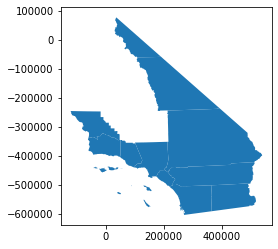

In [41]:
SoCal_counties_gdf.plot()


In [49]:
SoCal_counties_gdf.crs
SoCal_counties_gdf_utm10 = SoCal_counties_gdf.to_crs( "epsg:26910")
SoCal_counties_gdf_utm10.area
SoCal_counties_gdf_utm10.geometry.type.unique()

array(['MultiPolygon', 'Polygon'], dtype=object)

<AxesSubplot:>

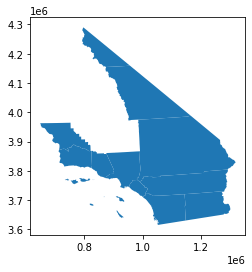

In [50]:
SoCal_counties_gdf_utm10.plot()

In [51]:
SoCal_counties_gdf_utm10.geometry.unary_union

In [57]:
SoCal_counties_gdf_utm10.index
wd_in_SoCA = waterdistict_gdf_utm10.intersects(SoCal_counties_gdf_utm10.geometry.unary_union)

In [56]:
pas_in_ac

0       False
1       False
2       False
3       False
4       False
        ...  
3570     True
3571     True
3572     True
3573    False
3574    False
Length: 3575, dtype: bool

In [58]:
waterdistict_gdf_utm10[wd_in_SoCA].head()

,OBJECTID,AGENCYNAME,SOURCE,AGENCYUNIQ,LASTMODIFI,MODIFIEDBY,SOURCECOMM,Date_Data_,GlobalID,geometry
64,86,West Kern Water District,ATLAS_WMAS,2679,2021-04-27,ATLAS_WMAS,None,2021-04-27,{0E6F48B9-551B-43CA-8239-01664586267D},"MULTIPOLYGON (((799341.483 3920916.130, 799356..."
96,126,Santa Maria Valley Water Conservation District,ATLAS_WMAS,2219,2021-04-27,ATLAS_WMAS,None,2021-04-27,{108CBC33-1A5F-4B24-96FB-9DD8602A3176},"POLYGON ((728039.353 3876930.880, 728266.166 3..."
102,134,Atascadero Mutual Water Company,ATLAS_WMAS,107,2021-04-27,ATLAS_WMAS,"Atascadero MWC, minor edits to existing layer",2021-04-27,{76248E3E-EC7B-410D-81A7-4FE759834159},"POLYGON ((715648.023 3926827.972, 715654.512 3..."
105,137,Avila Beach Community Service District,ATLAS_WMAS,116,2021-04-27,ATLAS_WMAS,None,2021-04-27,{A7984023-E204-4883-A590-02D7EAA03E67},"POLYGON ((705936.766 3895256.117, 705952.873 3..."
113,149,Templeton Community Services District,ATLAS_WMAS,2457,2021-04-27,ATLAS_WMAS,None,2021-04-27,{0894E3B5-0DFD-46F5-ACD1-0D29A72A17B0},"POLYGON ((707272.195 3935087.230, 707269.989 3..."
